In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Import neo4j DB: 4/4

Code to translate v2.7.4_PIS-model.xlsx to neo4j database. 

## Setup

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pandas as pd
import re
import numpy as np
import os
from IPython.display import Image
from IPython.display import display

In [4]:
from py2neo import Graph, Node, Relationship

In [5]:
import helpers

In [6]:
from importlib import reload

Connect to graph via docker-compose link. See http://localhost:7474/browser/

In [7]:
graph = Graph(host="neo4j")

In [8]:
from pathlib import Path

base_path = Path("..")
parsed_path = base_path / "data" / "parsed"

## Components summary

In [9]:
q = '''MATCH (n) RETURN DISTINCT n.name AS name'''
nodes = graph.run(q).data()
all_nodes_in_components = set([(d["name"]) for d in nodes])

In [10]:
all_nodes_in_components

{'&alpha;/&beta; hydroxylase',
 '&beta;-carotene isomerase',
 '12,13-EOT',
 '12-OH-JA-Ile',
 '13-HPOT',
 '4CLL',
 '6K1',
 '6K2',
 '9-cis-&beta;-carotene',
 '9-cis-10&prime;-apo-&beta;-carotenal',
 'AAO',
 'ACC',
 'ACH',
 'ACO',
 'ACS',
 'ACX',
 'ADK',
 'ADP',
 'ADT',
 'AGO',
 'AHK',
 'AHP',
 'AMP',
 'AOC',
 'AOS',
 'AOX',
 'APT',
 'APX',
 'ARF',
 'ARR',
 'ASK',
 'ATP',
 'ATPB',
 'AUX-signalling',
 'Ade',
 'Ado',
 'Anthocyanin-accumulation',
 'BA',
 'BA2H',
 'BG',
 'BIK1',
 'BR1',
 'CAM',
 'CAMTA',
 'CAT',
 'CBP60G',
 'CCD',
 'CDPK',
 'CI',
 'CKX',
 'CL',
 'CLA',
 'CLH',
 'CM',
 'CO',
 'CO2-deficiency',
 'COI1',
 'CP',
 'CPS',
 'CRT',
 'CTR',
 'CTS',
 'CUL',
 'CYP',
 'CYP71B',
 'CYP735',
 'CYP94',
 'Ca2+',
 'Chor',
 'Class I Clp ATPase',
 'Cu2+',
 'DAMP/HAMP',
 'DELLA',
 'DMAPP',
 'DXPS',
 'DZ',
 'DZ7G',
 'DZ9G',
 'DZOG',
 'DZR',
 'DZRMP',
 'DZROG',
 'EBF',
 'EDS1',
 'EDS5',
 'EIN2',
 'EIN3(like)',
 'ERF',
 'ERF/EDF',
 'ESP/NSP',
 'ET',
 'ETP',
 'ETR',
 'F-box/LRR-repeat',
 'GA1',
 'GA1

In [11]:
len(all_nodes_in_components)

320

In [12]:
node_labels = helpers.node_labels

In [13]:
node_dict = {}
for label in node_labels:
    q = '''MATCH (n:%s) RETURN DISTINCT n.name'''%label
    s = set([d['n.name'] for d in graph.run(q).data()])
    print(label, len(s))
    node_dict[label] = s


PlantCoding 162
PlantNonCoding 9
PlantAbstract 7
Complex 3
ExternalEntity 3
ExternalCoding 14
ExternalNonCoding 0
ExternalAbstract 0
Process 6
MetaboliteFamily 6
Metabolite 110
PseudoNode 0


In [14]:
all_species = ['ath', 'osa', 'stu', 'sly']

### Reactions sheet

In [186]:
df_edges = pd.read_csv(parsed_path / "edges-sheet.tsv", sep="\t", index_col=0)

In [187]:
df_edges.head()

,Status,AddedBy,ConnID,Species,input1_ID,input1_level,input1_localisation,input1_type,input2_ID,input2_level,...,output1_ath_homologues,output1_osa_homologues,output1_sly_homologues,output1_stu_homologues,input1_location,input2_location,input3_location,output1_location,reaction_type,reaction_id
0,forCB,KG,Conn001,ath,L-Met,family,ER,metabolite,SAMS,clade,...,NaN,NaN,NaN,NaN,endoplasmic reticulum,endoplasmic reticulum,putative:cytoplasm,endoplasmic reticulum,catalysis/auto-catalysis,rx00001
1,forCB,KG,Conn002,ath,SAMe,family,ER,metabolite,ACS,family,...,NaN,NaN,NaN,NaN,endoplasmic reticulum,endoplasmic reticulum,putative:cytoplasm,endoplasmic reticulum,catalysis/auto-catalysis,rx00002
2,forCB,KG,Conn003,ath,ACC,family,ER,metabolite,ACO,family,...,NaN,NaN,NaN,NaN,endoplasmic reticulum,endoplasmic reticulum,putative:cytoplasm,endoplasmic reticulum,catalysis/auto-catalysis,rx00003
3,forCB,KG,Conn004,ath,Cu2+,family,cytoplasm,metabolite,HMA,family,...,NaN,NaN,NaN,NaN,cytoplasm,endoplasmic reticulum,putative:cytoplasm,endoplasmic reticulum,translocation,rx00004
4,forCB,KG,Conn005,ath,ETR,family,ER,protein,Cu2+,family,...,"AT3G04580,AT1G66340,AT1G04310,AT3G23150,AT2G40940",NaN,NaN,NaN,endoplasmic reticulum,endoplasmic reticulum,putative:cytoplasm,endoplasmic reticulum,protein activation,rx00005


In [188]:
df_edges[df_edges['input1_ID']=="DZ"][['input1_ID', 'input1_newID', 'input1_label']]

,input1_ID,input1_newID,input1_label
341,DZ,DZ,Metabolite
345,DZ,DZ,Metabolite
346,DZ,DZ,Metabolite
347,DZ,DZ,Metabolite
348,DZ,DZ,Metabolite
349,DZ,DZ,Metabolite
350,DZ,DZ,Metabolite
351,DZ,DZ,Metabolite
352,DZ,DZ,Metabolite


In [189]:
def generate_list(subdf, ids, new_name, homologues=True):
    col_suffixes = ['_newID', '_location', '_label', '_form']
    new_col_suffixes = ['_name', '_location', '_label', '_form']

    if homologues:
        col_suffixes += homologue_cols
        new_col_suffixes += homologue_cols
        
    for old_suf, new_suf in zip(col_suffixes, new_col_suffixes):
        new_col = new_name + new_suf
        old_cols = [id_ + old_suf for id_ in ids]
        subdf[new_col] = subdf[old_cols].apply(lambda x: [i for i in x.values], axis=1)
        
        
def rename_target(subdf, id_, new_name, homologues=True):
    col_suffixes = ['_newID', '_location', '_label', '_form']
    new_col_suffixes = ['_name', '_location', '_label', '_form']

    if homologues:
        col_suffixes += homologue_cols
        new_col_suffixes += homologue_cols

    for old_suf, new_suf in zip(col_suffixes, new_col_suffixes):
        new_col = new_name + new_suf
        old_col = id_ + old_suf
        subdf[new_col] = subdf[old_col]

In [190]:
def get_x_nodes(df, x):
    rows_with_x = set()
    for i, row in df.iterrows():
        for col_prefix in ['input1', 'input2', 'input3', 'output1']:
            if row[col_prefix + "_newID"] in x:
                rows_with_x.add(i)
    return rows_with_x

In [191]:
def number_input_different(df, homologues=True, catalyst=False):
    ''' If catalyst is True, it is the last "input" col. '''

    if catalyst:
        # two inputs, input2 -> catalyst
        subdf2 = df[df["input3_newID"].isna()].copy()
        generate_list(subdf2, ['input1'], 'substrate', homologues=homologues)
        rename_target(subdf2, 'input2', 'catalyst', homologues=homologues)

        # three inputs, input3 -> catalyst
        subdf3 = df[~df["input3_newID"].isna()].copy()
        generate_list(subdf3, ['input1', 'input2'], 'substrate', homologues=homologues)        
        rename_target(subdf3, 'input3', 'catalyst', homologues=homologues)
        
    else:
        # two inputs
        subdf2 = df[df["input3_newID"].isna()].copy()
        generate_list(subdf2, ['input1', 'input2'], 'substrate', homologues=homologues)

        # three inputs
        subdf3 = df[~df["input3_newID"].isna()].copy()
        generate_list(subdf3, ['input1', 'input2', 'input3'], 'substrate', homologues=homologues)
    
    # combine
    new_subdf = subdf2.append(subdf3)
    rename_target(new_subdf, 'output1', 'product', homologues=homologues)
    
    return new_subdf

In [192]:
df_edges.columns

Index(['Status', 'AddedBy', 'ConnID', 'Species', 'input1_ID', 'input1_level',
       'input1_localisation', 'input1_type', 'input2_ID', 'input2_level',
       'input2_localisation', 'input2_type', 'input3_ID', 'input3_level',
       'input3_localisation', 'input3_type', 'ReactionEffect', 'ReactionMode',
       'Modifications', 'output1_ID', 'output1_level', 'output1_localisation',
       'output1_type', 'TrustLevel', 'Literature', 'AdditionalInfo', 'ModelV',
       'origin', 'trust_level', 'external_links', 'input1_form', 'input2_form',
       'input3_form', 'output1_form', 'species', 'input1_newID',
       'input1_label', 'input2_newID', 'input2_label', 'input3_newID',
       'input3_label', 'output1_newID', 'output1_label',
       'input1_ath_homologues', 'input1_osa_homologues',
       'input1_sly_homologues', 'input1_stu_homologues',
       'input2_ath_homologues', 'input2_osa_homologues',
       'input2_sly_homologues', 'input2_stu_homologues',
       'input3_ath_homologues', 'inp

In [193]:
# transcription genes
substrate_cols_wo_homologues = ['substrate_name', 'substrate_form', 'substrate_label', 'substrate_location']
product_cols_wo_homologues = ['product_name', 'product_form', 'product_label',  'product_location']
catalyst_cols_wo_homologues = ['catalyst_name', 'catalyst_form', 'catalyst_label', 'catalyst_location']

homologue_cols = [f"_{x}_homologues" for x in all_species]

substrate_cols = [ f'substrate{x}' for x in ['_name', '_label', '_form', '_location']] +\
                [f"substrate{x}" for x in homologue_cols]
catalyst_cols = [ f'catalyst{x}' for x in ['_name', '_label', '_form', '_location']] +\
                [f"catalyst{x}" for x in homologue_cols] 
product_cols = [ f'product{x}' for x in ['_name', '_label', '_form', '_location']] +\
                [f"product{x}" for x in homologue_cols]

reaction_standard_columns = ['AddedBy', 'Species', 
       'AdditionalInfo',  'external_links', 'trust_level',
       'ModelV', 'ReactionEffect', 'reaction_type', 'Modifications', 'reaction_id']

In [194]:
def read_dict(file):
    d = {}
    with open(file, "r") as f:
        for line in f:
            key, value = line.strip().split("\t")
            d[key] = value
    return d

In [195]:
node_to_family = read_dict(parsed_path / "node_to_family.tsv")
clade_to_family = read_dict(parsed_path / "clade_to_family.tsv")

In [196]:
def node_id_to_node_label(id_):

    query = '''MATCH (s) WHERE s.name=$x 
               RETURN s.name AS substrate_name, labels(s) AS substrate_label'''
    
    cursor = graph.run(query, x=id_)
    d = cursor.data()
    
    if len(d) == 0:
        print(id_, d, "no hit")
        return ""
    elif len(d) == 1:
        s = set(d[0]['substrate_label']) - set(['Family'])
        return s.pop()
    else:
        print(id_, d, 'multiple hits') # should be impossible
        return ""

### Add complexes

In [26]:
already_defined_complexes = node_dict['Complex']

In [27]:
complexes_to_add = set(pd.read_csv(parsed_path / "complexes_to_add.tsv", sep="\t", header=None)[0]) - set(already_defined_complexes)

In [28]:
len(complexes_to_add)

91

In [29]:
rows_w_new_complex = get_x_nodes(df_edges, complexes_to_add)

In [30]:
want_cols = ['reaction_type', 'Modifications']
for prefix in ['input1', 'input2', 'input3', 'output1']:
    want_cols += [f"{prefix}_{x}" for x in ['newID', 'location', 'label', 'form']]

df_new_complex = df_edges.loc[rows_w_new_complex, want_cols]

In [31]:
# first complexes defined by binding/oglimerisation reactions
key = 'binding/oligomerisation'
subdf = df_new_complex.loc[df_new_complex['reaction_type'] == key]

binding_w_catalyst = subdf.loc[subdf['Modifications'] == 'with catalyst']
binding_wo_catalyst = subdf.loc[subdf['Modifications'] != 'with catalyst']

In [32]:
subdf_wo_catalyst = number_input_different(binding_wo_catalyst, homologues=False)
subdf_w_catalyst = number_input_different(binding_w_catalyst, homologues=False, catalyst=True)

In [33]:
subdf_wo_catalyst = subdf_wo_catalyst[['substrate_name', 'substrate_label', 'substrate_form', 'output1_newID', 'product_name']]
subdf_w_catalyst = subdf_w_catalyst[['substrate_name', 'substrate_label', 'substrate_form', 'output1_newID', 'product_name']]

In [34]:
new_subdf = pd.concat([subdf_wo_catalyst, subdf_w_catalyst])

In [35]:
new_subdf.drop_duplicates('product_name', keep='first', inplace=True)

In [36]:
new_subdf.head()

,substrate_name,substrate_label,substrate_form,output1_newID,product_name
5,"[CTR, ETR]","[PlantCoding, PlantCoding]","[protein_active, protein_active]",CTR|ETR,CTR|ETR
7,"[ET, ETR]","[Metabolite, PlantCoding]","[metabolite, protein_active]",ET|ETR,ET|ETR
10,"[ETP, SCF]","[PlantCoding, Complex]","[protein, complex]",ETP|SCF,ETP|SCF
15,"[EBF, SCF]","[PlantCoding, Complex]","[protein, complex]",EBF|SCF,EBF|SCF
17,"[JAZ, EIN3(like)]","[PlantCoding, PlantCoding]","[protein, protein_active]",EIN3(like)|JAZ,EIN3(like)|JAZ


In [37]:
binding_defined_complexes = set(new_subdf['product_name'].values)

In [38]:
len(binding_defined_complexes)

85

In [39]:
# other complexes
other_complexes = set()
for i , row in df_new_complex.iterrows():
    for col_prefix in ['input1', 'input2', 'input3', 'output1']:
        if row[col_prefix + "_label"] == 'Complex':
            c = row[col_prefix + "_newID"]
            if not ((c in binding_defined_complexes) or (c in already_defined_complexes)):
                other_complexes.add(row[col_prefix + "_newID"])

In [40]:
other_complexes

{'CAM|Ca2+',
 'COI1|OMR1',
 'EDS1|NPR1|TGA2,5,6',
 'EDS5|NPR1|TGA2,5,6',
 'GSTU24|ROS',
 'NPR1|PAD4|TGA2,5,6'}

In [41]:
other_complexes = pd.DataFrame(other_complexes, columns=['output1_newID'])

In [42]:
def get_subunits(x):
    if '|' in x:
        return x.split('|')
    else:
        return []

In [43]:
other_complexes['substrate_og_name'] = other_complexes['output1_newID'].apply(get_subunits)
other_complexes['substrate_form'] = other_complexes['substrate_og_name'].apply(lambda x: ["" for c in x])
other_complexes['product_name'] = other_complexes['output1_newID']

In [44]:
other_complexes

,output1_newID,substrate_og_name,substrate_form,product_name
0,"NPR1|PAD4|TGA2,5,6","[NPR1, PAD4, TGA2,5,6]","[, , ]","NPR1|PAD4|TGA2,5,6"
1,CAM|Ca2+,"[CAM, Ca2+]","[, ]",CAM|Ca2+
2,COI1|OMR1,"[COI1, OMR1]","[, ]",COI1|OMR1
3,"EDS5|NPR1|TGA2,5,6","[EDS5, NPR1, TGA2,5,6]","[, , ]","EDS5|NPR1|TGA2,5,6"
4,"EDS1|NPR1|TGA2,5,6","[EDS1, NPR1, TGA2,5,6]","[, , ]","EDS1|NPR1|TGA2,5,6"
5,GSTU24|ROS,"[GSTU24, ROS]","[, ]",GSTU24|ROS


In [45]:
def get_name(ids_):
    names = []
    for x in ids_:
        label1 = node_id_to_node_label(x)
        if not (label1 == ''):
            names.append(x)
        else:
            if x in clade_to_family:
                names.append(clade_to_family[x])
                print('using as clade id to get family\t', x, "\t", clade_to_family[x])

            elif x in node_to_family:
                names.append(node_to_family[x])
                print('using as node id to get family\t', x, "\t", node_to_family[x])

            else:
                names.append(x)
    
    return names

In [46]:
def components_missing_label(ids_):
    labels = []
    for x in ids_:
        label1 = node_id_to_node_label(x)
        if label1 == '':
            if x in clade_to_family:
                label1 = node_id_to_node_label(clade_to_family[x])
                print('using as clade id to get family label\t', x, "\t", label1)
            elif x in node_to_family:
                label1 = node_id_to_node_label(node_to_family[x])
                print('using as node id to get family label\t', x, "\t", label1)
        
        if label == '':
            print(x)
        labels.append(label1)
    return labels


In [47]:
other_complexes['substrate_name'] = other_complexes['substrate_og_name'].apply(get_name)
other_complexes['substrate_label'] = other_complexes['substrate_name'].apply(components_missing_label)

NPR1 [] no hit
using as node id to get family	 NPR1 	 NPR
TGA2,5,6 [] no hit
using as clade id to get family	 TGA2,5,6 	 TGA
OMR1 [] no hit
using as clade id to get family	 OMR1 	 OMR
NPR1 [] no hit
using as node id to get family	 NPR1 	 NPR
TGA2,5,6 [] no hit
using as clade id to get family	 TGA2,5,6 	 TGA
NPR1 [] no hit
using as node id to get family	 NPR1 	 NPR
TGA2,5,6 [] no hit
using as clade id to get family	 TGA2,5,6 	 TGA
GSTU24 [] no hit
using as node id to get family	 GSTU24 	 GST


In [49]:
del other_complexes['substrate_og_name']

In [50]:
new_complexes = other_complexes.append(new_subdf, sort=True)

In [52]:
new_complexes.columns

Index(['output1_newID', 'product_name', 'substrate_form', 'substrate_label',
       'substrate_name'],
      dtype='object')

In [53]:
# save new complexes 
label = 'Complex'
f = f'{label}-new-components.tsv'
want_cols = 'product_name'
new_complexes[want_cols].to_csv(f'../data/import/{f}', sep="\t", index=None, header=True)

In [54]:
print(new_complexes.shape[0])

91


In [55]:
query = helpers.bioelement_node_query(f, "Complex", 
                           n_name="line.product_name")
#print(query)
qr = graph.run(query)
if not new_complexes.shape[0] == qr.stats()['nodes_created']:
     raise Exception

In [56]:
exploded_new_subdf = helpers.unnesting(new_complexes, ['substrate_name', 'substrate_label', 'substrate_form']).drop_duplicates()

In [60]:
exploded_new_subdf[exploded_new_subdf['product_name']=='D14|MAX2|SCF']

,substrate_name,substrate_label,substrate_form,output1_newID,product_name
318,&alpha;/&beta; hydroxylase,PlantCoding,protein_active,D14|MAX2|SCF,D14|MAX2|SCF
318,F-box/LRR-repeat,PlantCoding,protein_active,D14|MAX2|SCF,D14|MAX2|SCF
318,SCF,Complex,complex,D14|MAX2|SCF,D14|MAX2|SCF


In [61]:
exploded_new_subdf.tail()

,substrate_name,substrate_label,substrate_form,output1_newID,product_name
312,CAT,PlantCoding,protein,ACX3|CAT2,ACX3|CAT2
312,ACX,PlantCoding,protein,ACX3|CAT2,ACX3|CAT2
318,&alpha;/&beta; hydroxylase,PlantCoding,protein_active,D14|MAX2|SCF,D14|MAX2|SCF
318,F-box/LRR-repeat,PlantCoding,protein_active,D14|MAX2|SCF,D14|MAX2|SCF
318,SCF,Complex,complex,D14|MAX2|SCF,D14|MAX2|SCF


In [62]:
exploded_new_subdf[~exploded_new_subdf['substrate_label'].isin(node_labels)]

,substrate_name,substrate_label,substrate_form,output1_newID,product_name


In [63]:
# component to complex edges
edge_type = 'COMPONENT_OF'
want_cols = ['substrate_name', 'substrate_form', 'substrate_label', 'product_name']

for t, this_subdf in exploded_new_subdf[exploded_new_subdf['substrate_label'].isin(node_labels)].groupby("substrate_label"):
    f = f'{edge_type}-{label}-{t}-edges.tsv'  
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")

    query = helpers.make_create_type_of_edge_query(f, 'COMPONENT_OF',
                           source_label=t, target_label="Complex",
                           source_name="line.substrate_name", target_name="line.product_name",
                           #source_form="line.substrate_form"
                          )
    #print(query)
    qr = graph.run(query)

    print(t, this_subdf.shape[0], qr.stats()['relationships_created'])    
    if not this_subdf.shape[0] == qr.stats()['relationships_created']:
        print("\tnot all edges created")

Complex 16 16
ExternalCoding 29 29
ExternalEntity 2 2
Metabolite 10 10
MetaboliteFamily 2 2
PlantAbstract 4 4
PlantCoding 126 126
Process 2 2


# Add reactions

In [64]:
def pretty_print_result(t, df, qr, input_type, multiplier=1):
    if input_type in ['nodes', 'relationships']:
        key = input_type + '_created'
    else:
        key = input_type
    
    try:
        stat = qr.stats()[key]
    except:
        stat = 0
    
    print(f"{t:20}\t{df.shape[0]:3}\t{stat:3}", end="")
    if df.shape[0]*multiplier == stat:
        print()
    
    elif df.shape[0]*multiplier < stat:
        print(f"\t**too many {input_type} created**")
    else:
        print(f"\t**not all {input_type} created**")

In [65]:
df_edges.index.duplicated().sum()

0

## binding / oligomerisation

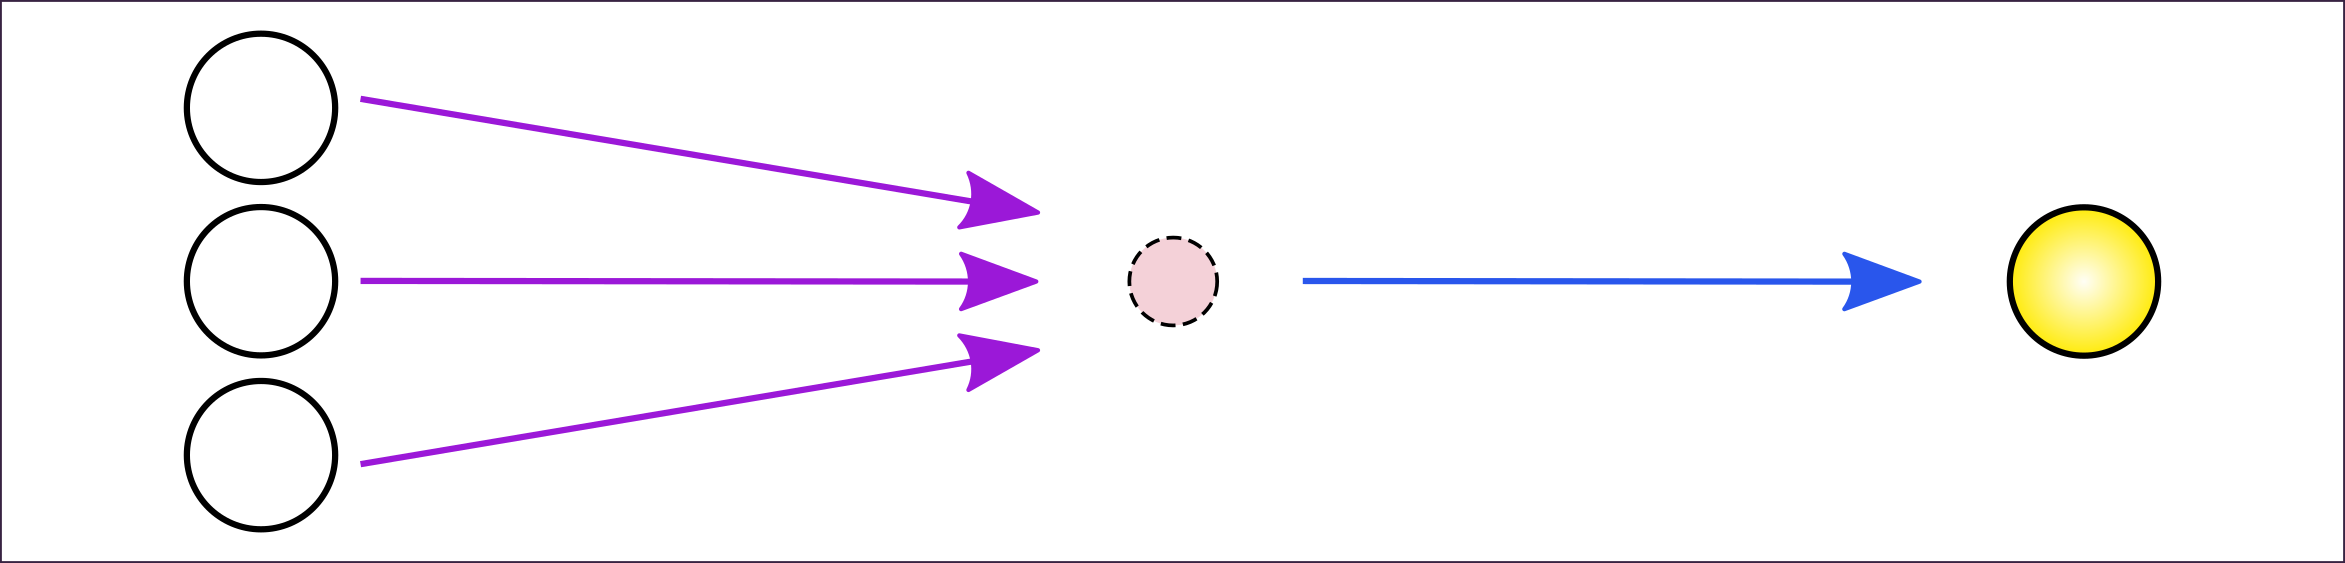

In [66]:
Image(filename='./reaction_types/activation/binding_oligomerisation.png')

In [67]:
key = 'binding/oligomerisation'
reaction_type = "BINDING_OGLIMERISATION"
subdf = df_edges.loc[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

BINDING_OGLIMERISATION 104


In [68]:
binding_wo_catalyst = subdf.loc[subdf['Modifications'] != 'with catalyst']
binding_w_catalyst = subdf.loc[subdf['Modifications'] == 'with catalyst']

In [69]:
subdf_wo_catalyst = number_input_different(binding_wo_catalyst)
subdf_w_catalyst = number_input_different(binding_w_catalyst, catalyst=True)

### Without catalyst

In [70]:
# make pseudo nodes
f = f"{reaction_type}-pseudo.tsv"
subdf_wo_catalyst[reaction_standard_columns].to_csv(f"../data/import/{f}", sep="\t", index=None)
query = helpers.pseudo_node_query(f, name="line.reaction_id")

In [71]:
!head ../data/import/$f

AddedBy	Species	AdditionalInfo	external_links	trust_level	ModelV	ReactionEffect	reaction_type	Modifications	reaction_id
KG	ath	When ETR is active, more ETR(a)/CTR(a) complex exists. RTE1 increases the formation of ETR/CTR complex.	doi:10.1104/pp.107.104299,doi:10.1073/pnas.0605528103	R1	v1.0	activation	binding/oligomerisation		rx00006
KG	ath	Modelled as ET competitively binding CTR(a) complex. Without ethylene: EIN2 is targeted for degradation by ETP1/2 (F-box proteins), EIN3/EIL1 are targeted for degradation by EBF1/2 (F-box proteins). Ethylene inhibits ETR-CTR complex.	doi:10.1105/tpc.001768	R1	v1.0	activation	binding/oligomerisation		rx00008
KG	ath	Technically the ETR(a)-CTR(a) complex keeps EIN2-C domain phosphorylated. In the presence of ethylene, CTR in the complex turns inactive, therefore allowing the cleavage of EIN2 C-terminal domain.	doi:10.1093/mp/ssr042,doi:10.1073/pnas.0605528103,doi:10.1042/bj20091102,doi:10.1073/pnas.1214848109,doi:10.1016/j.pbi.2008.06.011,doi:10.1093/

In [72]:
qr = graph.run(query)
pretty_print_result('PseudoNode', subdf_wo_catalyst, qr, 'nodes')

PseudoNode          	103	103


In [73]:
explode_cols = substrate_cols
exploded_new_subdf = helpers.unnesting(subdf_wo_catalyst, explode_cols)#.drop_duplicates()

In [74]:
# binding substrate edges
want_cols = reaction_standard_columns + substrate_cols

for t, this_subdf in exploded_new_subdf.groupby("substrate_label"):
    f = f"{reaction_type}-{t}-substrate_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE', 
                                                    "substrate", "dne",
                                                    source_label=t, 
                                                    target_label="PseudoNode", 
                                                    target_name="line.reaction_id"
                                                   )

    qr = graph.run(query)

    pretty_print_result(t, this_subdf, qr, 'relationships')


Complex             	 16	 16
ExternalCoding      	 30	 30
ExternalEntity      	  3	  3
Metabolite          	 32	 32
PlantAbstract       	  4	  4
PlantCoding         	131	131
Process             	  3	  3


In [75]:
subdf_wo_catalyst[subdf_wo_catalyst['ConnID'].isin(exploded_new_subdf[exploded_new_subdf["substrate_label"]=="nan"]['ConnID'].unique())][['ConnID', 'input1_newID', 'input2_newID', 'input3_newID', 'substrate_name']]

,ConnID,input1_newID,input2_newID,input3_newID,substrate_name


In [76]:
for x in this_subdf['ConnID'].unique():
    print(x)

Conn115
Conn117
Conn119


In [77]:
f = f"{reaction_type}-product_edges.tsv"
want_cols = reaction_standard_columns + product_cols
subdf_wo_catalyst[want_cols].to_csv(f'../data/import/{f}', sep="\t", index=None)

In [78]:
subdf_wo_catalyst[subdf_wo_catalyst["product_name"].isna()][product_cols + ["output1_ID", "output1_newID", "ConnID"]]

,product_name,product_label,product_form,product_location,product_ath_homologues,product_osa_homologues,product_stu_homologues,product_sly_homologues,output1_ID,output1_newID,ConnID


In [79]:
# binding product edges
query = helpers.make_create_reaction_edge_query(f, "PRODUCT", 
                                                "dne", "product",
                                                source_name="line.reaction_id", 
                                                source_label="PseudoNode"
                                               )
qr = graph.run(query)
pretty_print_result('-', subdf_wo_catalyst, qr, 'relationships')

-                   	103	103


In [80]:
q = '''LOAD CSV WITH HEADERS FROM  'file:///BINDING_OGLIMERISATION-product_edges.tsv' AS line FIELDTERMINATOR '	'
       OPTIONAL MATCH (source:PseudoNode { name:line.reaction_id})
       OPTIONAL MATCH (target { name:line.product_name})

        WITH source, target, line
            WHERE source IS NULL OR target is NULL
            RETURN target, line.reaction_id, line.product_name
           '''


result = graph.run(q)

In [81]:
d = result.data(); d

[]

In [82]:
rx_ids = [x['line.reaction_id'] for x in d]

In [83]:
subdf_wo_catalyst[subdf_wo_catalyst['reaction_id'].isin(rx_ids)][['Status', 'ConnID', 'output1_ID']]

,Status,ConnID,output1_ID


### With catalyst

In [84]:
subdf_w_catalyst

,Status,AddedBy,ConnID,Species,input1_ID,input1_level,input1_localisation,input1_type,input2_ID,input2_level,...,catalyst_stu_homologues,catalyst_sly_homologues,product_name,product_location,product_label,product_form,product_ath_homologues,product_osa_homologues,product_stu_homologues,product_sly_homologues
93,forCB,KG,Conn094,ath,NPR1,node,cytoplasm,protein,NPR1,node,...,NaN,NaN,NPR1|NPR1,cytoplasm,Complex,complex_active,NaN,NaN,NaN,NaN


In [85]:
subdf_w_catalyst.shape[0]

1

In [86]:
explode_cols = substrate_cols
exploded_new_subdf = helpers.unnesting(subdf_w_catalyst, explode_cols).drop_duplicates()

In [87]:
# binding substrate edges

want_cols = reaction_standard_columns + substrate_cols + catalyst_cols

for t, this_subdf in exploded_new_subdf.groupby("substrate_label"):
    f = f"{reaction_type}-{t}-catalyst-substrate_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE',
                                                    "substrate", "catalyst",
                                                    source_label=t
                                                   )
    qr = graph.run(query)
    pretty_print_result(t, this_subdf, qr, 'relationships')

PlantCoding         	  1	  1


In [88]:
f = f"{reaction_type}-catalyst-product_edges.tsv"
want_cols = reaction_standard_columns + catalyst_cols + product_cols
subdf_w_catalyst[want_cols].to_csv(f'../data/import/{f}', sep="\t", index=None)

In [89]:
# binding product edges
query = helpers.make_create_reaction_edge_query(f, "PRODUCT",
                                                "catalyst", "product"
                                               )
qr = graph.run(query)
pretty_print_result('-', subdf_w_catalyst, qr, 'relationships')

-                   	  1	  1


## catalysis / auto-catalysis

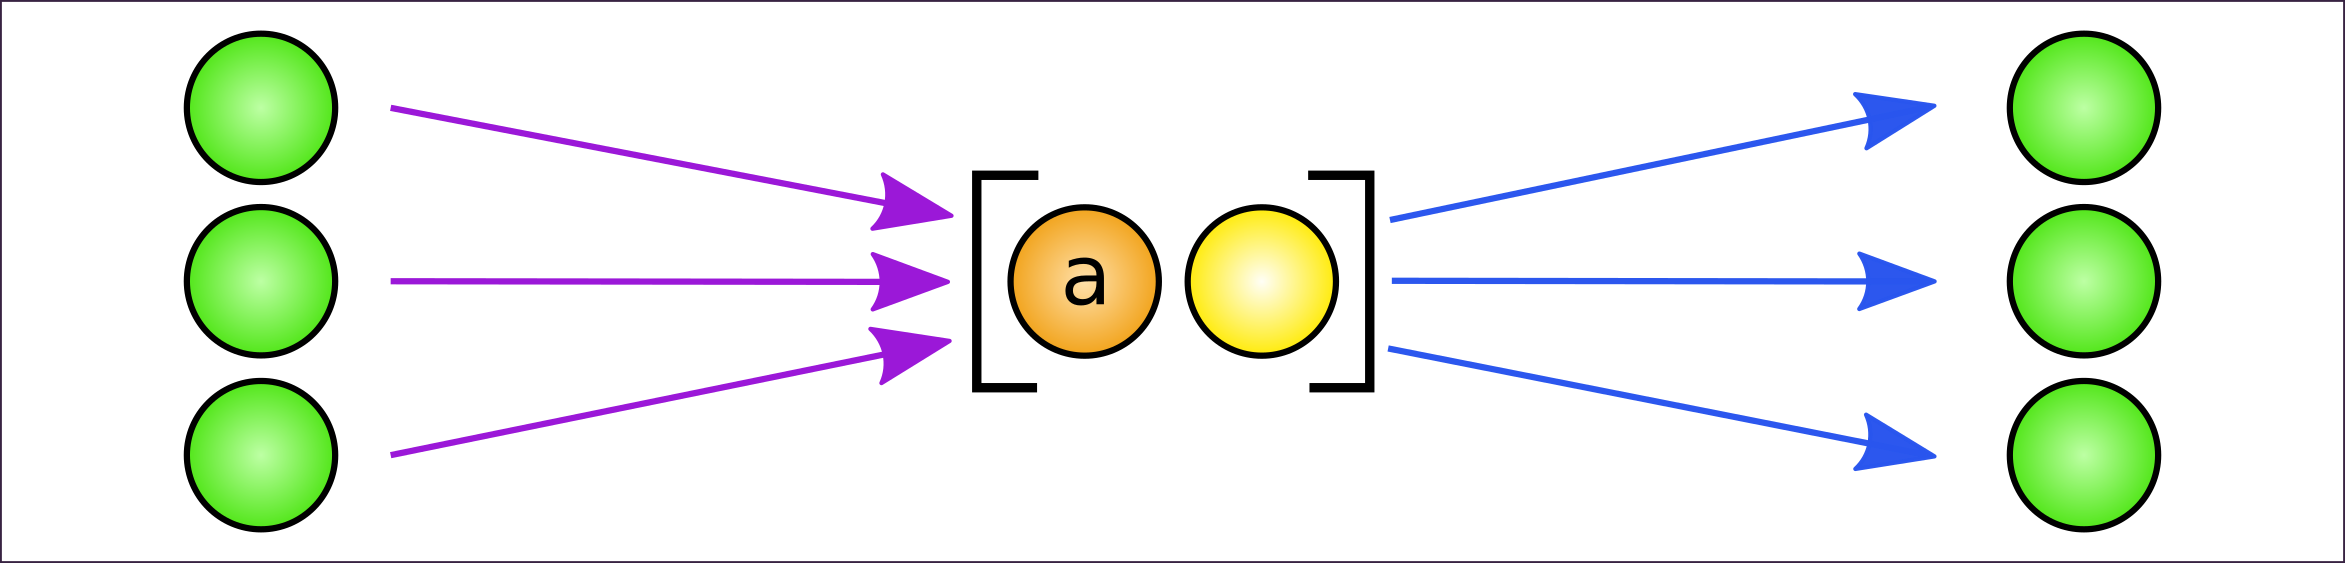

In [117]:
Image(filename='./reaction_types/activation/catalysis_auto_catalysis.png')

In [118]:
key = 'catalysis/auto-catalysis'
reaction_type = 'CATALYSIS'
subdf = df_edges[df_edges['reaction_type'] == key]
print(reaction_type, subdf.shape[0])

CATALYSIS 79


In [119]:
# with and without catalyst

In [120]:
subdf[subdf['input2_ID'].isna() & subdf['input3_ID'].isna()]

,Status,AddedBy,ConnID,Species,input1_ID,input1_level,input1_localisation,input1_type,input2_ID,input2_level,...,output1_ath_homologues,output1_osa_homologues,output1_sly_homologues,output1_stu_homologues,input1_location,input2_location,input3_location,output1_location,reaction_type,reaction_id
378,[TBD],AG,Conn389,Ath,tZRMP,node,cytoplasm?,metabolite,NaN,NaN,...,NaN,NaN,NaN,NaN,putative:cytoplasm,putative:cytoplasm,putative:cytoplasm,putative:cytoplasm,catalysis/auto-catalysis,rx00379


In [121]:
catalysis_wo_catalyst = subdf[subdf['input2_ID'].isna() & subdf['input3_ID'].isna()]
catalysis_w_catalyst = subdf[~(subdf['input2_ID'].isna() & subdf['input3_ID'].isna())]

### With catalyst

In [122]:
subdf_w_catalyst = number_input_different(catalysis_w_catalyst, catalyst=True)
new_subdf = number_input_different(subdf_w_catalyst, catalyst=True)

In [123]:
exploded_new_subdf = helpers.unnesting(new_subdf, substrate_cols)

In [124]:
# substrate to catalyst
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols

for t, this_subdf in exploded_new_subdf.groupby("substrate_label"):
    f = f"{reaction_type}-{t}-substrate_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE', 
                                                    "substrate", "catalyst",
                                                    source_label=t
                                                   )
    qr = graph.run(query)
    pretty_print_result(t, this_subdf, qr, 'relationships')

Metabolite          	 79	 79
PlantCoding         	 21	 21


In [125]:
q = '''LOAD CSV WITH HEADERS FROM  'file:///CATALYSIS-Metabolite-substrate_edges.tsv' AS line FIELDTERMINATOR '	'
       OPTIONAL MATCH (source { name:line.substrate_name})
       OPTIONAL MATCH (target { name:line.catalyst_name})

        WITH source, target, line
            WHERE source IS NULL OR target is NULL
            RETURN source.name, line.substrate_name,  target.name, line.catalyst_name, line.reaction_id
           '''

result = graph.run(q)
result.data()

[]

In [127]:
# catalyst to product
want_cols = reaction_standard_columns + catalyst_cols + product_cols
for t, this_subdf in new_subdf.groupby("product_label"):
    f = f"{reaction_type}-{t}-product_edges.tsv"    
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'PRODUCT', 
                                                    "catalyst", "product",
                                                    target_label=t
                                                   )    
    qr = graph.run(query)

    pretty_print_result(t, this_subdf, qr, 'relationships')

Metabolite          	 76	 76
MetaboliteFamily    	  2	  2


### Without catalyst

In [128]:
rename_target(catalysis_wo_catalyst, 'output1', 'product')
rename_target(catalysis_wo_catalyst, 'input1',  'substrate')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [129]:
catalysis_wo_catalyst['reaction_id']

378    rx00379
Name: reaction_id, dtype: object

In [130]:
# make pseudo nodes
f = f"{reaction_type}-pseudo.tsv"
catalysis_wo_catalyst[reaction_standard_columns].to_csv(f"../data/import/{f}", sep="\t", index=None)
query = helpers.pseudo_node_query(f, name="line.reaction_id")

In [131]:
qr = graph.run(query)
pretty_print_result('PseudoNode', catalysis_wo_catalyst, qr, 'nodes')

PseudoNode          	  1	  1


In [132]:
# binding substrate edges
want_cols = reaction_standard_columns + substrate_cols

for t, this_subdf in catalysis_wo_catalyst.groupby("substrate_label"):
    f = f"{reaction_type}-{t}-substrate_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE', 
                                                    "substrate", "dne",
                                                    source_label=t, 
                                                    target_label="PseudoNode", 
                                                    target_name="line.reaction_id"
                                                   )

    qr = graph.run(query)

    pretty_print_result(t, this_subdf, qr, 'relationships')


MetaboliteFamily    	  1	  1


In [133]:
f = f"{reaction_type}-product_edges.tsv"
want_cols = reaction_standard_columns + product_cols
catalysis_wo_catalyst[want_cols].to_csv(f'../data/import/{f}', sep="\t", index=None)

In [134]:
# binding product edges
query = helpers.make_create_reaction_edge_query(f, "PRODUCT", 
                                                "dne", "product",
                                                source_name="line.reaction_id", 
                                                source_label="PseudoNode"
                                               )
qr = graph.run(query)
pretty_print_result('-', catalysis_wo_catalyst, qr, 'relationships')

-                   	  1	  1


In [135]:
q = '''MATCH ()-[r:SUBSTRATE {reaction_type:"catalysis/auto-catalysis"}]->() RETURN r'''
c = graph.run(q).data()
len(c) # should be ??

101

In [136]:
q = '''MATCH ()-[r:PRODUCT {reaction_type:"catalysis/auto-catalysis"}]->() RETURN r'''
c = graph.run(q).data()
len(c) # should be ??

79

## dissociation

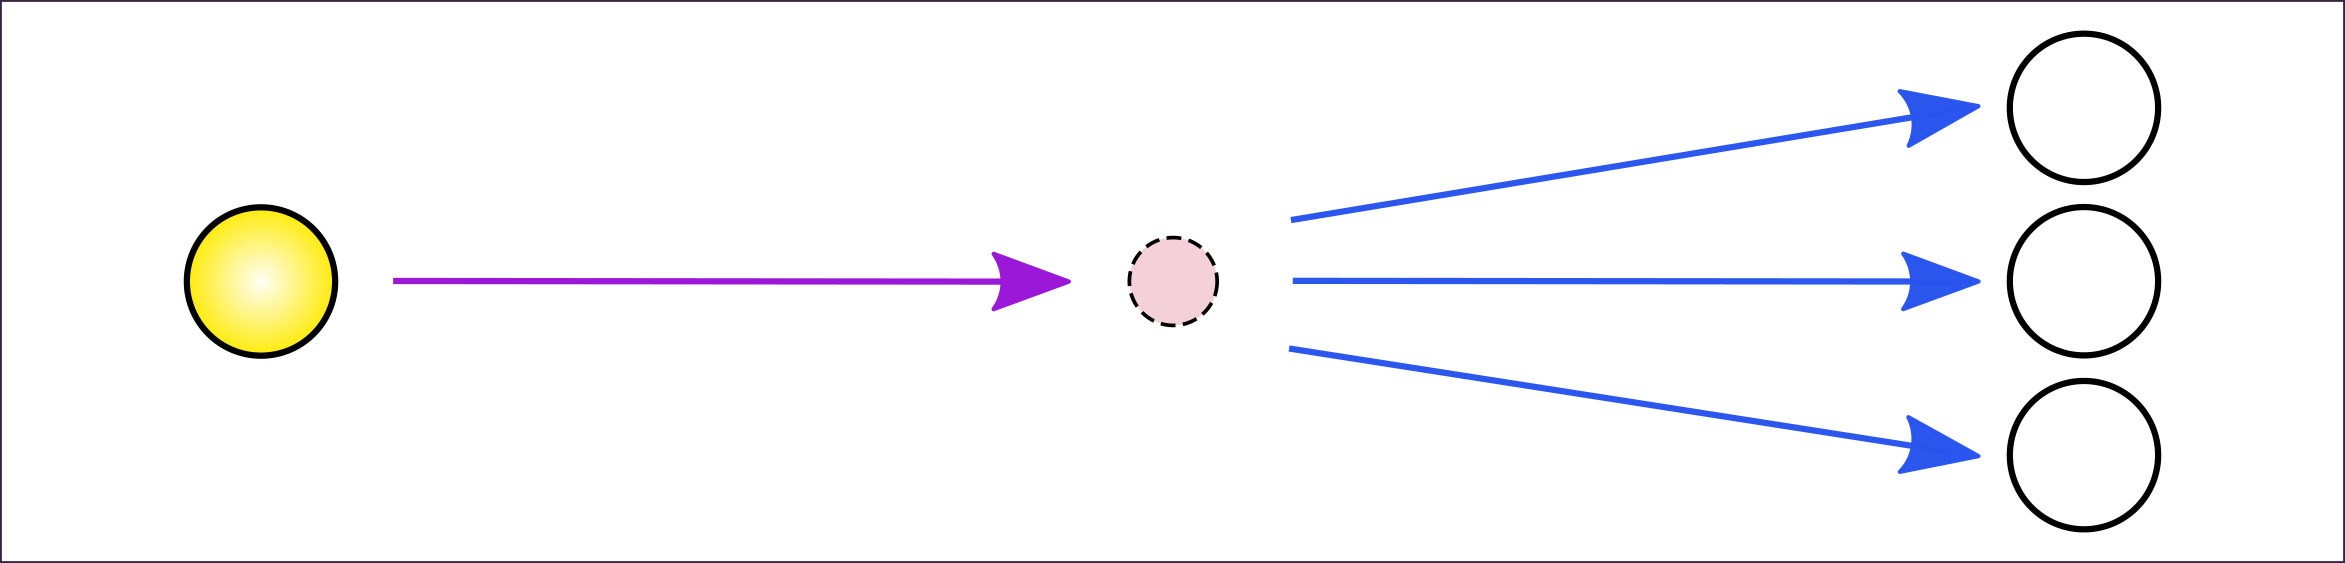

In [137]:
Image(filename='./reaction_types/activation/dissociation.png')

In [138]:
key = 'dissociation'
reaction_type = 'DISSOCIATION'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

DISSOCIATION 1


In [139]:
subdf

,Status,AddedBy,ConnID,Species,input1_ID,input1_level,input1_localisation,input1_type,input2_ID,input2_level,...,output1_ath_homologues,output1_osa_homologues,output1_sly_homologues,output1_stu_homologues,input1_location,input2_location,input3_location,output1_location,reaction_type,reaction_id
95,forCB,KG,Conn096,ath,NPR1|NPR1,family,cytoplasm,complex,TRX-H,family,...,AT1G64280,NaN,NaN,NaN,cytoplasm,cytoplasm,putative:cytoplasm,cytoplasm,dissociation,rx00096


In [140]:
rename_target(subdf, 'output1', 'product')
rename_target(subdf, 'input1',  'substrate')
rename_target(subdf, 'input2',  'catalyst')

In [141]:
# substrate to node edge

f =  f"{reaction_type}-{t}-substrate_edges.tsv" 
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols
subdf.to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE',
                                                "substrate", "catalyst"
                              )
qr = graph.run(query)
pretty_print_result("-", subdf, qr, 'relationships')

-                   	  1	  1


In [142]:
# catalyst to product edge

f =  f"{reaction_type}-{t}-product_edges.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols
subdf.to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'PRODUCT',
                                                "catalyst" , "product"
                              )
qr = graph.run(query)
pretty_print_result("-", subdf, qr, 'relationships')

-                   	  1	  1


## degradation

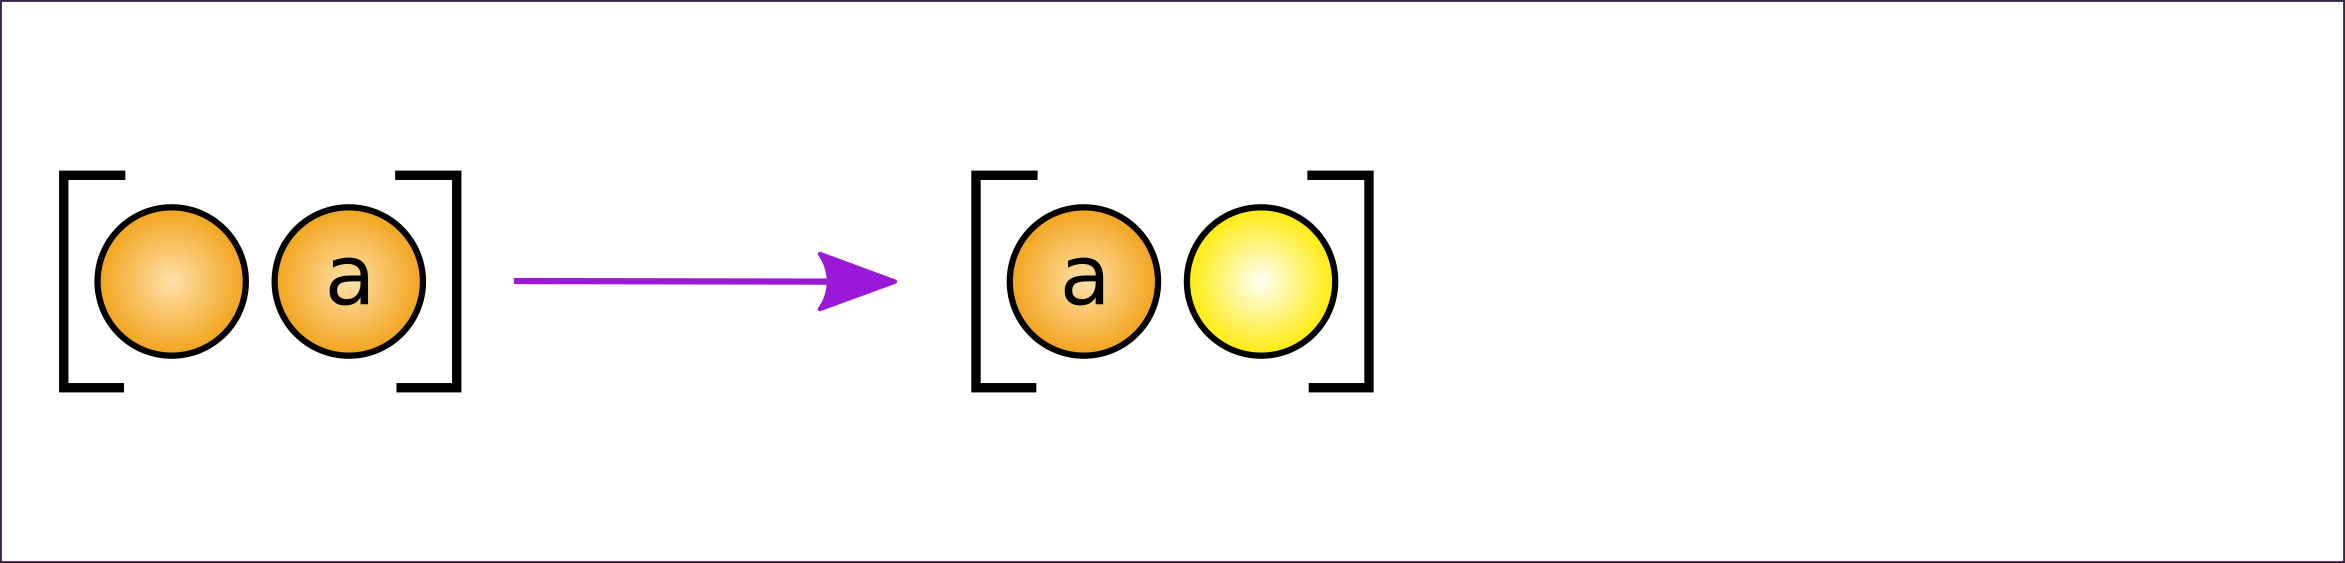

In [143]:
Image(filename='./reaction_types/inhibition/degradation.png')

In [144]:
key = 'degradation/secretion'
reaction_type = 'DEGRADATION_SECRETION'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

DEGRADATION_SECRETION 32


In [145]:
rename_target(subdf, 'input1',  'catalyst')
rename_target(subdf, 'input2',  'substrate')

In [146]:
# substrate to catalyst edge

f =  f"{reaction_type}-substrate_edges.tsv" 
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols
subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE',
                                                "substrate", "catalyst"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	 32	 32


In [147]:

q = '''LOAD CSV WITH HEADERS FROM  'file:///DEGRADATION_SECRETION-substrate_edges.tsv' AS line FIELDTERMINATOR '	'
       OPTIONAL MATCH (source { name:line.substrate_name})
       OPTIONAL MATCH (target { name:line.catalyst_name})

        WITH source, target, line
            WHERE source IS NULL OR target is NULL
            RETURN source.name, line.substrate_name,  target.name, line.catalyst_name, line.reaction_id
           '''

result = graph.run(q)
result.data()

[]

In [148]:
subdf[subdf['reaction_id'] == 'rx00320']

,Status,AddedBy,ConnID,Species,input1_ID,input1_level,input1_localisation,input1_type,input2_ID,input2_level,...,catalyst_stu_homologues,catalyst_sly_homologues,substrate_name,substrate_location,substrate_label,substrate_form,substrate_ath_homologues,substrate_osa_homologues,substrate_stu_homologues,substrate_sly_homologues
319,[TBD],JALR,Conn320,ath/osa,D14|MAX2|SCF,family,cytoplasm?,complex [active],D53,node,...,NaN,NaN,Class I Clp ATPase,putative:cytoplasm,PlantCoding,protein_active,NaN,OS11G0104300,NaN,NaN


## translocation

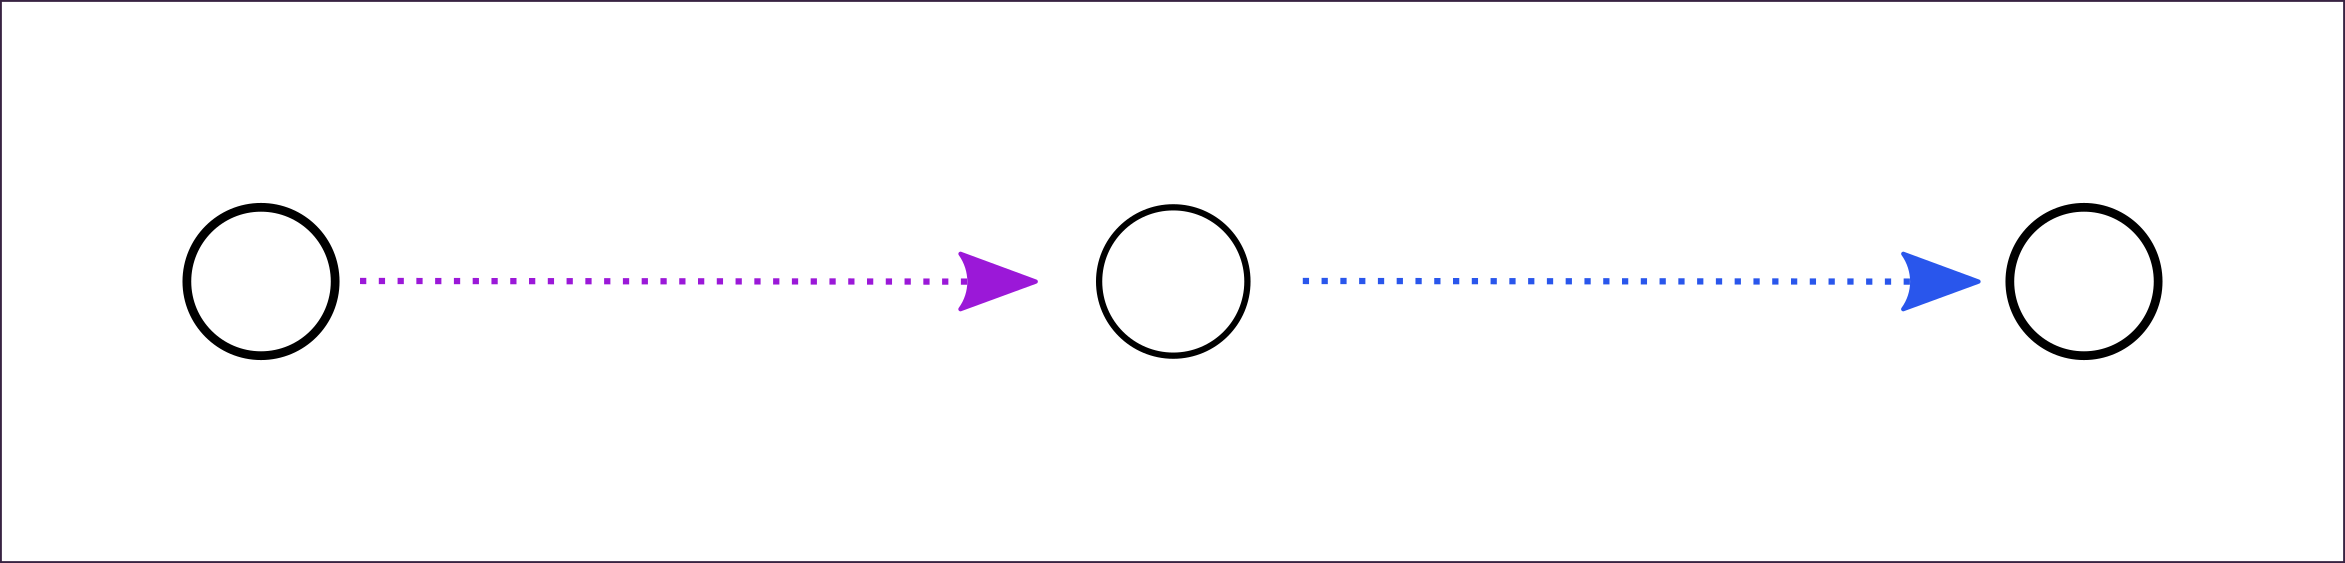

In [149]:
Image(filename='./reaction_types/activation/translocation.png')

In [150]:
key = 'translocation'
reaction_type = 'TRANSLOCATION'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

TRANSLOCATION 5


In [151]:
rename_target(subdf, 'output1', 'product')
rename_target(subdf, 'input1',  'substrate')
rename_target(subdf, 'input2',  'catalyst')

In [152]:
# substrate to catalyst edge

f =  f"{reaction_type}-substrate_edges.tsv" 
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols
subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'TRANSLOCATE_FROM',
                                                "substrate", "catalyst"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	  5	  5


In [153]:
# catalyst to product edge
f =  f"{reaction_type}--product_edges.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols
subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'TRANSLOCATE_TO',
                                                "catalyst" , "product"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	  5	  5


## protein activation

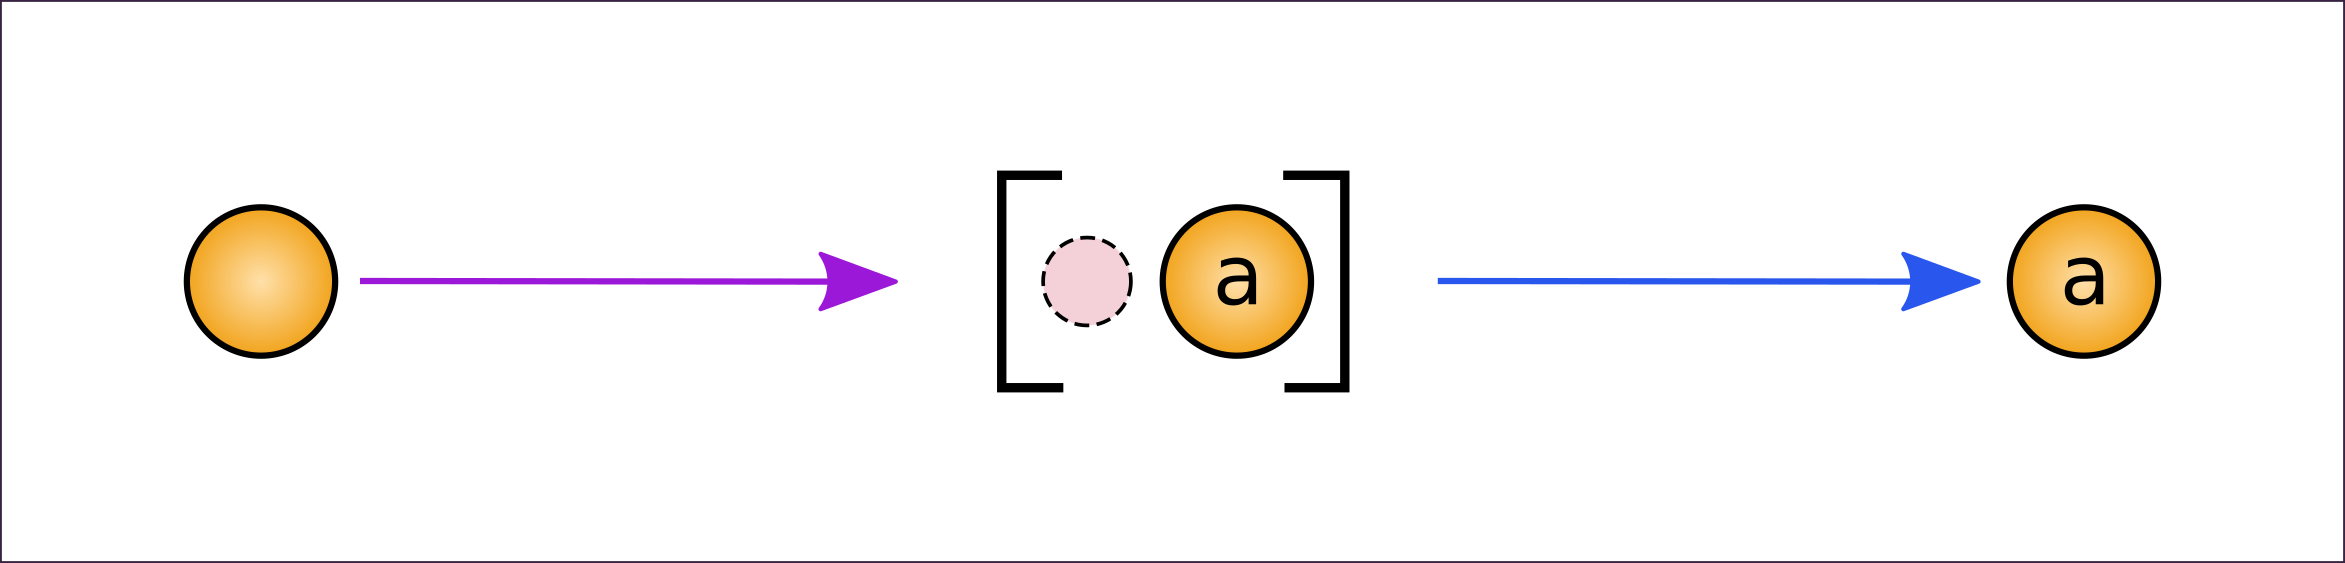

In [154]:
Image(filename='./reaction_types/activation/protein_activation.png')

In [155]:
key = 'protein activation'
reaction_type = 'PROTEIN_ACTIVATION'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

PROTEIN_ACTIVATION 52


In [156]:
rename_target(subdf, 'output1', 'product')
rename_target(subdf, 'input1',  'catalyst')
rename_target(subdf, 'input2',  'substrate')

In [157]:
# substrate to node edge

f =  f"{reaction_type}-substrate_edges.tsv" 
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols
subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE',
                                                "substrate", "catalyst"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	 52	 52


In [158]:
# catalyst to product edge
f =  f"{reaction_type}-product_edges.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols
subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'PRODUCT',
                                                "catalyst" , "product"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	 52	 52


## protein deactivation

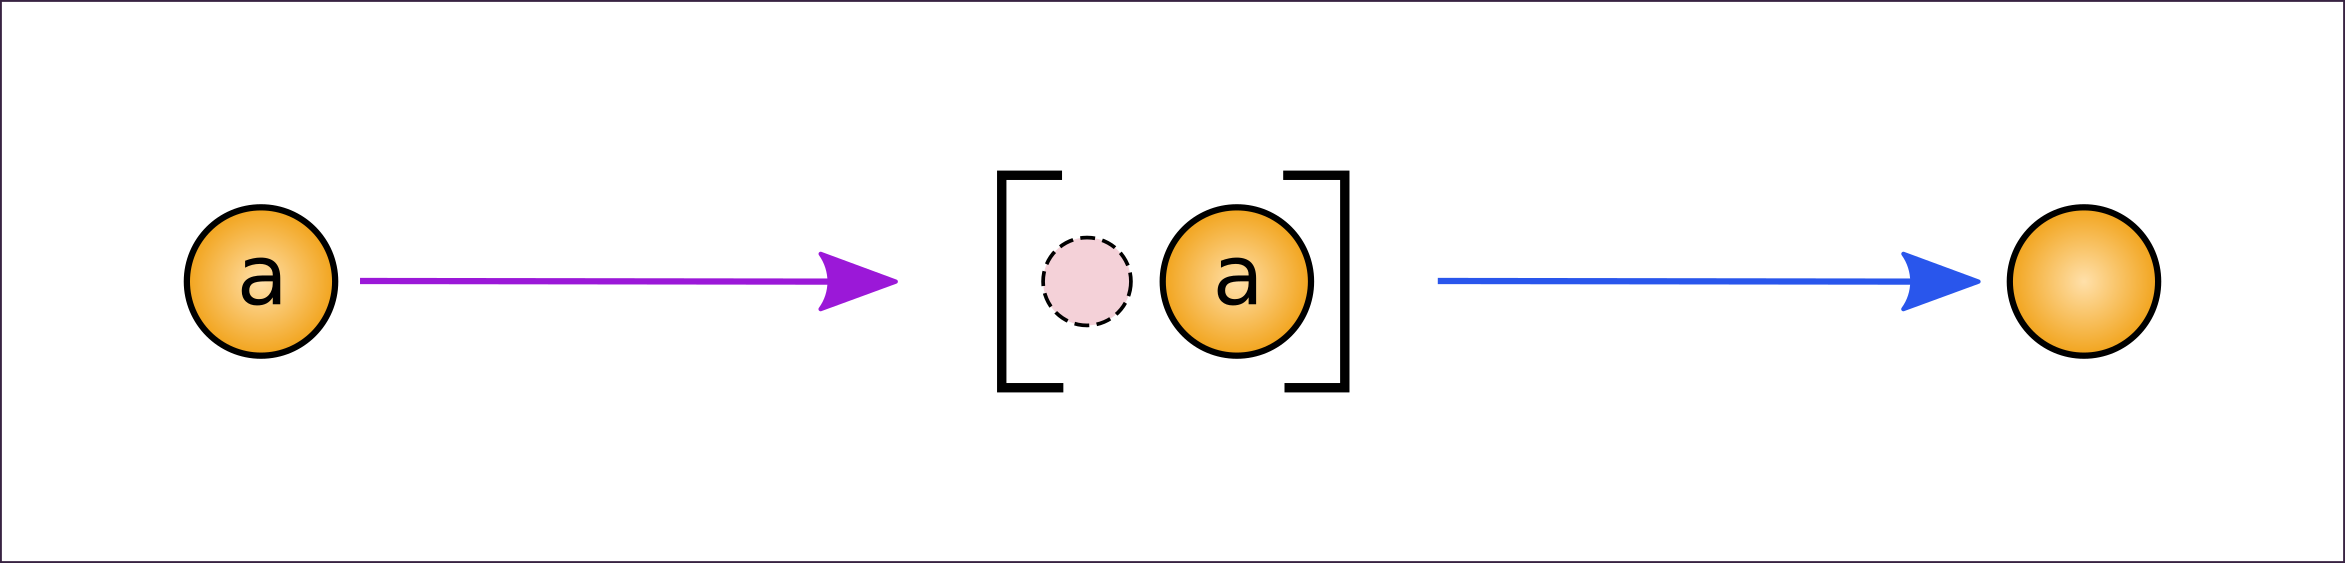

In [159]:
Image(filename='./reaction_types/inhibition/protein_deactivation.png')

In [160]:
key = 'protein deactivation'
reaction_type = 'PROTEIN_DEACTIVATION'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

PROTEIN_DEACTIVATION 4


In [161]:
rename_target(subdf, 'output1', 'product')
rename_target(subdf, 'input1',  'substrate')
rename_target(subdf, 'input2',  'catalyst')

In [162]:
# substrate to catalyst edge
f =  f"{reaction_type}-substrate_edges.tsv" 
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols
subdf.to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE',
                                                "substrate", "catalyst"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	  4	  4


In [163]:
# catalyst to product edge
f =  f"{reaction_type}-product_edges.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols
subdf.to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'PRODUCT',
                                                "catalyst" , "product"
                              )
qr = graph.run(query)
pretty_print_result('-', subdf, qr, 'relationships')

-                   	  4	  4


## transcriptional / translational regulation

In [197]:
reaction_type = 'TRANSCRIPTIONAL_TRANSLATIONAL'
keys = ['transcriptional/translational induction', 'transcriptional/translational repression']
subdf = df_edges[df_edges['reaction_type'].isin(keys)]
print(reaction_type, subdf.shape[0])

TRANSCRIPTIONAL_TRANSLATIONAL 79


In [198]:
def number_input_different_reverse(df, homologues=True):
    ''' If catalyst is True, they are the first "input" cols. 
    last one is left as substrate. '''

    # two inputs, input1 -> catalyst
    subdf2 = df[df["input3_newID"].isna()].copy()
    generate_list(subdf2, ['input1'], 'catalyst', homologues=homologues)
    rename_target(subdf2, 'input2', 'substrate', homologues=homologues)

    # three inputs, input1, input2 -> catalyst
    subdf3 = df[~df["input3_newID"].isna()].copy()
    generate_list(subdf3, ['input1', 'input2'], 'catalyst', homologues=homologues)        
    rename_target(subdf3, 'input3', 'substrate', homologues=homologues)
     
    # combine
    new_subdf = subdf2.append(subdf3)
    rename_target(new_subdf, 'output1', 'product', homologues=homologues)
    
    return new_subdf

In [199]:
new_subdf = number_input_different_reverse(subdf, homologues=True)

In [200]:
new_subdf[new_subdf['substrate_name'] != new_subdf['product_name']][["Status", "ConnID", 'substrate_name', 'product_name' ]]

,Status,ConnID,substrate_name,product_name
44,_TBD,Conn045,OMR,COI1|OMR1
92,_TBD,Conn093,PAD4,"NPR1|PAD4|TGA2,5,6"
115,_TBD,Conn116,EDS5,"EDS5|NPR1|TGA2,5,6"
117,_TBD,Conn118,EDS1,"EDS1|NPR1|TGA2,5,6"
119,_TBD,Conn120,PAD4,"NPR1|PAD4|TGA2,5,6"
148,_TBD,Conn149,GST,GSTU24|ROS


In [201]:
new_subdf[(  (new_subdf['substrate_form'] == 'gene') & (new_subdf['substrate_location'] != 'nucleus')  )][["Status", "ConnID"] + substrate_cols_wo_homologues]

,Status,ConnID,substrate_name,substrate_form,substrate_label,substrate_location
27,forCB,Conn028,LOX,gene,PlantCoding,chloroplast
97,forCB,Conn098,WRKY,gene,PlantCoding,cytoplasm
110,forCB,Conn111,TAS3,gene,PlantNonCoding,cytoplasm
123,forCB,Conn124,WRKY,gene,PlantCoding,cytoplasm
160,forCB,Conn161,PAD4,gene,PlantCoding,cytoplasm
186,forCB,Conn187,ICS,gene,PlantCoding,chloroplast
187,forCB,Conn188,ICS,gene,PlantCoding,chloroplast
188,forCB,Conn189,ICS,gene,PlantCoding,chloroplast
189,forCB,Conn190,ICS,gene,PlantCoding,chloroplast
192,forCB,Conn193,ACO,gene,PlantCoding,endoplasmic reticulum


In [202]:
#manualfix
new_subdf.loc[(  (new_subdf['substrate_form'] == 'gene') & (new_subdf['substrate_location'] != 'nucleus')  ), 'substrate_location'] = 'nucleus'

In [203]:
new_subdf[(  (new_subdf['product_form'].isin(['rna', 'ncRNA']) ))]#& (new_subdf['substrate_location'] != 'nucleus')  )][["Status", "ConnID"] + substrate_cols_wo_homologues]

,Status,AddedBy,ConnID,Species,input1_ID,input1_level,input1_localisation,input1_type,input2_ID,input2_level,...,substrate_stu_homologues,substrate_sly_homologues,product_name,product_location,product_label,product_form,product_ath_homologues,product_osa_homologues,product_stu_homologues,product_sly_homologues
110,forCB,KG,Conn111,ath,MIR390,family,cytoplasm,ncRNA,TAS3,family,...,NaN,NaN,TAS3,cytoplasm,PlantNonCoding,ncRNA,"AT5G49615,AT3G17185",NaN,NaN,NaN


In [204]:
new_subdf[(  (new_subdf['substrate_form'].isin(['rna', 'ncRNA'])) & (new_subdf['substrate_location'] != 'cytoplams')  )][["Status", "ConnID"] + substrate_cols_wo_homologues]

,Status,ConnID,substrate_name,substrate_form,substrate_label,substrate_location


In [205]:
new_subdf[(  (new_subdf['product_form'] == 'protein') & (new_subdf['product_location'] != 'cytoplasm')  )][["Status", "ConnID"] + product_cols_wo_homologues]

,Status,ConnID,product_name,product_form,product_label,product_location
11,forCB,Conn012,EBF,protein,PlantCoding,nucleus
20,forCB,Conn021,PR3,protein,PlantCoding,nucleus
21,forCB,Conn022,PR4,protein,PlantCoding,nucleus
24,forCB,Conn025,PDF1,protein,PlantCoding,nucleus
27,forCB,Conn028,LOX,protein,PlantCoding,chloroplast
45,forCB,Conn046,JAZ,protein,PlantCoding,nucleus
47,forCB,Conn048,MYC,protein,PlantCoding,nucleus
48,forCB,Conn049,CLH,protein,PlantCoding,nucleus
49,forCB,Conn050,JAL,protein,PlantCoding,nucleus
50,forCB,Conn051,PR13,protein,PlantCoding,nucleus


In [206]:
# manualfix
new_subdf.loc[(  (new_subdf['product_form'] == 'protein') & (new_subdf['product_location'] != 'cytoplasm')  ), 'product_location'] = 'cytoplasm'

In [207]:
new_subdf[~new_subdf['substrate_label'].isin(["PlantCoding", "PlantNonCoding"])][["Status", "ConnID"] + substrate_cols_wo_homologues] #+ catalyst_cols_wo_homologues + product_cols_wo_homologues]

,Status,ConnID,substrate_name,substrate_form,substrate_label,substrate_location
62,forCB,Conn063,Anthocyanin-accumulation,process,Process,cytoplasm
63,forCB,Conn064,Trichome-initiation,process,Process,cytoplasm


In [208]:
new_subdf[~new_subdf['product_label'].isin(["PlantCoding", "PlantNonCoding"])][["Status", "ConnID"] + product_cols_wo_homologues]

,Status,ConnID,product_name,product_form,product_label,product_location
44,_TBD,Conn045,COI1|OMR1,complex,Complex,nucleus
62,forCB,Conn063,Anthocyanin-accumulation,process_active,Process,cytoplasm
63,forCB,Conn064,Trichome-initiation,process_active,Process,cytoplasm
92,_TBD,Conn093,"NPR1|PAD4|TGA2,5,6",complex,Complex,nucleus
115,_TBD,Conn116,"EDS5|NPR1|TGA2,5,6",complex,Complex,nucleus
117,_TBD,Conn118,"EDS1|NPR1|TGA2,5,6",complex,Complex,nucleus
119,_TBD,Conn120,"NPR1|PAD4|TGA2,5,6",complex,Complex,nucleus
148,_TBD,Conn149,GSTU24|ROS,complex,Complex,nucleus


In [209]:
exploded_new_subdf = helpers.unnesting(new_subdf, catalyst_cols)

In [210]:
edge_label = "ACTIVATES"
reaction_type = 'transcriptional/translational induction'
reaction_type_nice = 'transcriptional_translational_induction'
act_subdf = exploded_new_subdf[exploded_new_subdf['reaction_type']==reaction_type]

# substrate to catalyst edge
f =  f"{reaction_type_nice}-{edge_label}.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols + substrate_cols
act_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

In [211]:
query = helpers.make_create_requlatory_edge_query(f, edge_label,
                                        "catalyst", "substrate", "product"
                              )
qr = graph.run(query)
pretty_print_result('-', act_subdf, qr, 'relationships')

-                   	 62	 62


In [212]:
edge_label = "INHIBITS"
reaction_type = 'transcriptional/translational repression'
reaction_type_nice = 'transcriptional_translational_repression'
inh_subdf = exploded_new_subdf[exploded_new_subdf['reaction_type']==reaction_type]

# substrate to catalyst edge
f =  f"{reaction_type_nice}-{edge_label}.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols + substrate_cols
inh_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

In [213]:
query = helpers.make_create_requlatory_edge_query(f, edge_label,
                                        "catalyst", "substrate", "product"
                              )
qr = graph.run(query)
pretty_print_result('-', inh_subdf, qr, 'relationships')

-                   	 19	 19


## cleavage/auto-cleavage

In [165]:
#Image(filename='./reaction_types/activation/cleavage_autocleavage.png')

In [168]:
key = 'cleavage/auto-cleavage'
reaction_type = 'CLEAVAGE_AUTOCLEAVAGE'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

CLEAVAGE_AUTOCLEAVAGE 29


In [169]:
cleavage_wo_catalyst = subdf[subdf['input2_ID'].isna() & subdf['input3_ID'].isna()]
cleavage_w_catalyst = subdf[~(subdf['input2_ID'].isna() & subdf['input3_ID'].isna())]

In [170]:
rename_target(cleavage_w_catalyst, 'output1', 'product')
rename_target(cleavage_w_catalyst, 'input1',  'substrate')
rename_target(cleavage_w_catalyst, 'input2',  'catalyst')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [171]:
# substrate to node edge

f =  f"{reaction_type}-{t}-substrate_edges.tsv" 
want_cols = reaction_standard_columns + substrate_cols + catalyst_cols
cleavage_w_catalyst.to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE',
                                                "substrate", "catalyst"
                              )
qr = graph.run(query)
pretty_print_result("-", cleavage_w_catalyst, qr, 'relationships')

-                   	 19	 19


In [172]:
# catalyst to product edge

f =  f"{reaction_type}-{t}-product_edges.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols
cleavage_w_catalyst.to_csv(f"../data/import/{f}", sep="\t", index=None)

query = helpers.make_create_reaction_edge_query(f, 'PRODUCT',
                                                "catalyst" , "product"
                              )
qr = graph.run(query)
pretty_print_result("-", cleavage_w_catalyst, qr, 'relationships')

-                   	 19	 19


In [173]:
rename_target(cleavage_wo_catalyst, 'output1', 'product')
rename_target(cleavage_wo_catalyst, 'input1',  'substrate')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [174]:
# make pseudo nodes
f = f"{reaction_type}-pseudo.tsv"
cleavage_wo_catalyst[reaction_standard_columns].to_csv(f"../data/import/{f}", sep="\t", index=None)
query = helpers.pseudo_node_query(f, name="line.reaction_id")

In [175]:
qr = graph.run(query)
pretty_print_result('PseudoNode', cleavage_wo_catalyst, qr, 'nodes')

PseudoNode          	 10	 10


In [176]:
# binding substrate edges
want_cols = reaction_standard_columns + substrate_cols

for t, this_subdf in cleavage_wo_catalyst.groupby("substrate_label"):
    f = f"{reaction_type}-{t}-substrate_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE', 
                                                    "substrate", "dne",
                                                    source_label=t, 
                                                    target_label="PseudoNode", 
                                                    target_name="line.reaction_id"
                                                   )

    qr = graph.run(query)

    pretty_print_result(t, this_subdf, qr, 'relationships')


Metabolite          	 10	 10


In [177]:
f = f"{reaction_type}-product_edges.tsv"
want_cols = reaction_standard_columns + product_cols
cleavage_wo_catalyst[want_cols].to_csv(f'../data/import/{f}', sep="\t", index=None)

In [178]:
# binding product edges
query = helpers.make_create_reaction_edge_query(f, "PRODUCT", 
                                                "dne", "product",
                                                source_name="line.reaction_id", 
                                                source_label="PseudoNode"
                                               )
qr = graph.run(query)
pretty_print_result('-', cleavage_wo_catalyst, qr, 'relationships')

-                   	 10	 10


## undefined

In [177]:
#Image(filename='./reaction_types/...png')

In [179]:
key = 'undefined'
reaction_type = 'UNDEFINED'
subdf = df_edges[df_edges['reaction_type'] == key].copy()
print(reaction_type, subdf.shape[0])

UNDEFINED 9


In [180]:
rename_target(subdf, 'output1', 'product')
rename_target(subdf, 'input2',  'substrate')
rename_target(subdf, 'input1',  'catalyst')

In [181]:
activation_subdf = subdf[subdf['ReactionEffect'] == 'activation' ]
inhibition_subdf = subdf[subdf['ReactionEffect'] == 'inhibition' ]

In [182]:
edge_label = "ACTIVATES"

# substrate to catalyst edge
f =  f"{reaction_type}-{edge_label}.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + substrate_cols
activation_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

In [183]:
query = helpers.make_create_requlatory_edge_query(f, edge_label,
                                        "catalyst", "substrate", "product"
                              )
qr = graph.run(query)
pretty_print_result('-', activation_subdf, qr, 'relationships')

-                   	  1	  1


In [184]:
edge_label = "INHIBITS"

# substrate to catalyst edge
f =  f"{reaction_type}-{edge_label}.tsv" 
want_cols = reaction_standard_columns + catalyst_cols + product_cols + substrate_cols
inhibition_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)

In [185]:
query = helpers.make_create_requlatory_edge_query(f, edge_label,
                                        "catalyst", "substrate", "product"
                              )
qr = graph.run(query)
pretty_print_result('-', inhibition_subdf, qr, 'relationships')

-                   	  8	  8


## END

In [ ]:

only_ge = new_subdf[['ConnID', 'Modifications'] + substrate_cols_wo_homologues + product_cols_wo_homologues].copy()

In [ ]:
# Check that duplicates based just on substrate name is 
# same as duplicates based on substrate and product cols
# I.e. droping duplicates is okay. 

x = only_ge[only_ge[["Modifications","substrate_name"]].duplicated()]
y = only_ge[only_ge[substrate_cols_wo_homologues + product_cols_wo_homologues].duplicated()]

bad_dups = only_ge.loc[set(x.index ) - set(y.index)].sort_values('substrate_name')
bad_dups

In [ ]:
for n in bad_dups['substrate_name']:
    display(only_ge[only_ge['substrate_name'] ==n])

In [ ]:
for g, this_subdf in only_ge.groupby('substrate_name'):
    print(g, this_subdf['Modifications'].unique())

In [ ]:
from collections import defaultdict

In [ ]:
sub = lambda : defaultdict(set)
D = defaultdict(sub)
for (gene, modification), this_subdf in only_ge.groupby(['substrate_name', 'Modifications']):
    if modification == 'translation':
        D[gene]['gene_localisation'].update(this_subdf['substrate_localisation'])
        D[gene]['rna_localisation'].update(this_subdf['product_localisation'])
    elif modification == 'transcription':
        D[gene]['rna_localisation'].update(this_subdf['substrate_localisation'])
        D[gene]['gene_product_localisation'].update(this_subdf['product_localisation'])
ge_properties = pd.DataFrame.from_dict(D, orient="index")
del D

In [ ]:
ge_properties

In [ ]:
only_ge.drop_duplicates(keep="first", inplace=True, subset=['substrate_name'])
only_ge = only_ge.set_index('substrate_name').join(ge_properties).reset_index()
#only_ge['ge_name'] = only_ge['substrate_name'] + "-expression"

In [ ]:
for c in ['rna_localisation', 'gene_product_localisation', 'gene_localisation']:
    only_ge[c] = only_ge[c].apply(lambda x:"" if x is np.nan else x.pop())

In [ ]:
want_cols = ['substrate_name', 'gene_product_localisation', 'rna_localisation', 'gene_localisation']


for t, this_subdf in only_ge.groupby("substrate_label"):
    
    f = f"{reaction_type}-{t}-GeneExpression.tsv" 
    this_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)
    
    query = '''USING PERIODIC COMMIT 500
               LOAD CSV WITH HEADERS FROM  'file:///{file_name}' AS line FIELDTERMINATOR '\t'
               MATCH (n:{label} {{name: line.substrate_name }}) 
               WITH n, line
                   SET n.gene_localisation = line.gene_localisation,
                       n.rna_localisation = line.rna_localisation,
                       n.gene_product_localisation = line.gene_product_localisation
                   '''.format(file_name=f, label=t, new_label=label)

    qr = graph.run(query)
    pretty_print_result(t, this_subdf, qr, 'properties_set', multiplier=3)

# label = "GeneExpression"
# want_cols = ['substrate_name', 'gene_product_localisation', 'rna_localisation', 'gene_localisation', 'ge_name']


# for t, this_subdf in only_ge.groupby("substrate_label"):
    
#     f = f"{reaction_type}-{t}-GeneExpression.tsv" 
#     this_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)
    
#     query = '''USING PERIODIC COMMIT 500
#                LOAD CSV WITH HEADERS FROM  'file:///{file_name}' AS line FIELDTERMINATOR '\t'
#                MATCH (n:{label} {{name: line.substrate_name }}) 
#                WITH n as map, line as line
#                    CREATE (copy:{new_label}) 
#                    SET copy=map
#                    SET copy.name = line.ge_name, 
#                        copy.gene_family = map.name,
#                        copy.gene_localisation = line.gene_localisation,
#                        copy.rna_localisation = line.rna_localisation,
#                        copy.gene_product_localisation = line.gene_product_localisation
#                    '''.format(file_name=f, label=t, new_label=label)

#     qr = graph.run(query)
#     pretty_print_result(t, this_subdf, qr, 'nodes')

In [ ]:
# want_cols = ['ge_name'] +  substrate_cols_wo_homologues + product_cols_wo_homologues

# for t, this_subdf in only_ge.groupby("substrate_label"):
    
#     f = f"{reaction_type}-{t}-GeneExpression-substrate_edges.tsv" 
#     this_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)
    
#     query = helpers.make_create_reaction_edge_query(f, 'SUBSTRATE', 
#                                                     "substrate", "dne",
#                                                     target_name="line.ge_name",
#                                                     source_label=t, 
#                                                     target_label="GeneExpression", 
#                                                    )

#     qr = graph.run(query)
#     pretty_print_result(t, this_subdf, qr, 'relationships')

In [ ]:
# want_cols = ['ge_name'] +  substrate_cols_wo_homologues + product_cols_wo_homologues

# for t, this_subdf in only_ge.groupby("substrate_label"):
    
#     f = f"{reaction_type}-{t}-GeneExpression-product_edges.tsv" 
#     this_subdf[want_cols].to_csv(f"../data/import/{f}", sep="\t", index=None)
    
#     query = helpers.make_create_reaction_edge_query(f, 'PRODUCT', 
#                                                     "dne", "product",
#                                                     source_name="line.ge_name",
#                                                     target_name="line.substrate_name",
#                                                     target_label=t, 
#                                                     source_label="GeneExpression", 
#                                                    )

#     qr = graph.run(query)
#     pretty_print_result(t, this_subdf, qr, 'relationships')

### transcriptional / translational induction

In [ ]:
Image(filename='./reaction_types/activation/transcriptional_translational_induction.png')

In [ ]:
key = 'transcription/translation induction'
reaction_type = 'TRANSCRIPTIONAL_TRANSLATIONAL_INDUCTION'
subdf = df_edges[df_edges['reaction_type'] == key]
print(reaction_type, subdf.shape[0])

In [ ]:
new_subdf = number_input_different_reverse(subdf, homologues=True)

In [ ]:
exploded_new_subdf = helpers.unnesting(new_subdf, catalyst_cols)

In [ ]:
exploded_new_subdf['ge_name'] = exploded_new_subdf['substrate_name'] + "-expression"

In [ ]:
# catalyst to gene-expression

want_cols = reaction_standard_columns + substrate_cols + catalyst_cols + ["ge_name"]

for t, this_subdf in exploded_new_subdf.groupby("catalyst_label"):
    f = f"{reaction_type}-{t}-catalyst_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'ACTIVATES', 
                                                    "catalyst", "substrate",
                                                    target_name="line.ge_name",
                                                    source_label=t,
                                                    target_label="GeneExpression", 
                                                    
                                                   )
    qr = graph.run(query)
    pretty_print_result(t, this_subdf, qr, 'relationships')

## transcription/translation repression

In [ ]:
Image(filename='./reaction_types/inhibition/transcriptional_translational_repression.png')

In [ ]:
key = 'transcription/translation repression'
reaction_type = 'TRANSCRIPTIONAL_TRANSLATIONAL_REPRESSION'
subdf = df_edges[df_edges['reaction_type'] == key]
print(reaction_type, subdf.shape[0])

In [ ]:
new_subdf = number_input_different_reverse(subdf, homologues=True)

In [ ]:
exploded_new_subdf = helpers.unnesting(new_subdf, catalyst_cols)

In [ ]:
exploded_new_subdf['ge_name'] = exploded_new_subdf['substrate_name'] + "-expression"

In [ ]:
# catalyst to gene-expression

want_cols = reaction_standard_columns + substrate_cols + catalyst_cols + ["ge_name"]

for t, this_subdf in exploded_new_subdf.groupby("catalyst_label"):
    f = f"{reaction_type}-{t}-catalyst_edges.tsv"
    this_subdf[want_cols].to_csv(f"../data/import/{f}", index=None, sep="\t")
    
    query = helpers.make_create_reaction_edge_query(f, 'INHIBTS', 
                                                    "catalyst", "substrate",
                                                    target_name="line.ge_name",
                                                    source_label=t,
                                                    target_label="GeneExpression", 
                                                    
                                                   )
    qr = graph.run(query)
    pretty_print_result(t, this_subdf, qr, 'relationships')

# END 